In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import analysis_functions

from IPython.display import display, HTML

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


--- 0.5856199264526367 seconds ---


In [2]:
'''Import data'''
#data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
#productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [3]:
'''Set sample names as index and shuffle data'''
#data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
#data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**Preprocessing of data**: we filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance in one sample, defined by the parameter $abun$. From previous analyses showed that we could set $abun = 0.01$ without degrading the performance. 

In [4]:
abun = 0.01

In [5]:
from analysis_functions import preprocess_df
data_rel = preprocess_df(data_rel,abun,True)
otus = list(data_rel.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 263


**Standardize data:**

In [6]:
scaler = StandardScaler()
data_rel = pd.DataFrame(scaler.fit_transform(data_rel.loc[:,otus]), index=data_rel.index, columns=otus)

Let's have a look at the heatmap of mutual **spearman correlations**: 

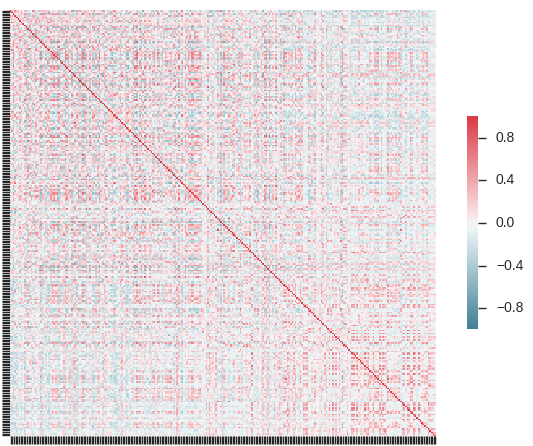

In [7]:
corr = data_rel.corr('spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

f, ax = plt.subplots()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, square=True, annot=False, xticklabels=False, yticklabels=False, linewidths=.0, cbar_kws={"shrink": .5}, ax=ax,  annot_kws={"size": 16})     
ax.tick_params(labelsize=0)
plt.show()

Let's compare statistical models using a **4x5 cross-validation** scheme: 
- Lasso
- Ridge regression
- Random Forest regression

In [8]:
from analysis_functions import perform_nested_lasso_cv, perform_nested_ridge_cv, perform_nested_RF_cv
from analysis_functions import get_r2

alphas_L, preds_L = perform_nested_lasso_cv(data_rel.loc[:,otus],hna)
alphas_RR, preds_RR = perform_nested_ridge_cv(data_rel.loc[:,otus],hna)
preds_RF = perform_nested_RF_cv(data_rel.loc[:,otus],hna)

r2_L = get_r2(hna,preds_L)
r2_RR = get_r2(hna,preds_RR)
r2_RF = get_r2(hna,preds_RF)

print('R2 Lasso: ' + str(r2_L))
print('R2 Ridge regression: ' + str(r2_RR))
print('R2 Random Forest regression: ' + str(r2_RF))

R2 Lasso: 0.722364221894
R2 Ridge regression: 0.672076556437
R2 Random Forest regression: 0.702354654902


Although Ridge regression seems the best model so far, the Lasso gives satisfying results. Let's use the _randomized_ Lasso to select the most important OTU's: 

In [9]:
from analysis_functions import perform_randomizedLasso

otu_scores = perform_randomizedLasso(data_rel.loc[:,otus], hna, alphas_L.mean())
otu_scores = pd.Series(otu_scores, index=otus)
otu_scores.sort_values(ascending=False,inplace=True)

#Display top-20 OTUs:
display(otu_scores.head(20))

Otu000173    1.000
Otu000060    0.972
Otu000001    0.940
Otu000242    0.886
Otu000335    0.854
Otu000059    0.792
Otu000119    0.790
Otu000264    0.782
Otu000160    0.782
Otu000279    0.712
Otu000088    0.694
Otu000022    0.628
Otu000255    0.612
Otu000149    0.594
Otu000005    0.580
Otu000343    0.566
Otu000411    0.548
Otu000090    0.524
Otu000137    0.520
Otu000142    0.516
dtype: float64

Each OTU is now associated with a certain score. The higher this score, the more it is selected when fitting a Lasso to a bootstrap subsample. We can now fit a threshold in order to determine the score which gives rise to the highest $R^2$, and thus, the optimal subset of OTU's. 

In [10]:
thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otu_scores
for thresh in thresholds: 
    scores = otu_scores[otu_scores.values > thresh]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_rel[features_new],hna)
        alphas, preds = perform_nested_lasso_cv(data_rel[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds)
    dummy+=1

/home/prubbens/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


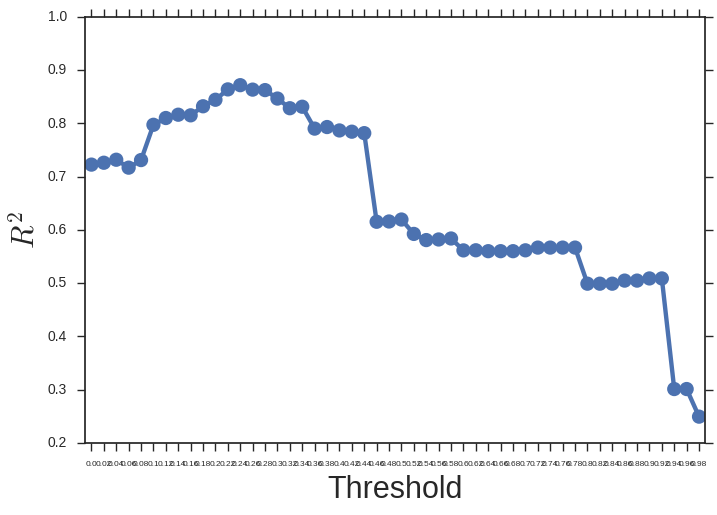

In [11]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Choose the value for which $R^2$ is maximal: 

In [12]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.871576660867
Optimal threshold = 0.24


Let's select the optimal list of OTU's and evaluate it's use when fitting a Lasso model to it: 

In [13]:
optimal_scores = otu_scores[otu_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

alphas_opt, preds_opt = perform_nested_lasso_cv(data_rel[selected_otus], hna)
r2_final = get_r2(hna, preds_opt)
print('r2: ' + str(r2_final))

from analysis_functions import get_r2_adj
r2_adj = get_r2_adj(r2_final, data_rel.shape[0], len(selected_otus))
print('r2_adj: ' + str(r2_adj))

Number of selected OTUs: 69
r2: 0.871576660867
r2_adj: 0.785545491933


This means that our optimal list contains now **69 OTU's** (which is less compared to using absolute abundances). This results in an $R^2_{adj} = 0.786$ (which is not bad). Additionally we can look at the pearson/spearman correlation between the selected OTU's and the HNA count: 

In [14]:
from scipy.stats import pearsonr, spearmanr
r_pearson = np.zeros(len(selected_otus))
r_spearman = np.zeros(len(selected_otus))
p_pearson = np.zeros(len(selected_otus))
p_spearman = np.zeros(len(selected_otus))

t=0
for otu in selected_otus: 
    r_pearson[t], p_pearson[t] = pearsonr(hna,data_rel.loc[:,otu])
    r_spearman[t], p_spearman[t] = spearmanr(hna,data_rel.loc[:,otu])
    t+=1

df = pd.DataFrame(optimal_scores)
df['r_pearson'] = r_pearson
df['p_pearson'] = p_pearson
df['r_spearman'] = r_spearman
df['p_spearman'] = p_spearman

display(df.head(20))

,0,r_pearson,p_pearson,r_spearman,p_spearman
Otu000173,1.000,0.515348,4.018788e-13,0.637819,3.840760e-21
Otu000060,0.972,0.484825,1.385982e-11,0.579761,6.386206e-17
Otu000001,0.940,-0.607440,7.953803e-19,-0.647329,6.384398e-22
Otu000242,0.886,0.206406,6.438479e-03,0.401913,4.231380e-08
Otu000335,0.854,0.350567,2.261836e-06,0.456832,2.657064e-10
Otu000059,0.792,-0.383904,1.847567e-07,-0.385266,1.657700e-07
Otu000119,0.790,0.309897,3.337530e-05,0.358827,1.248134e-06
Otu000264,0.782,0.028660,7.081755e-01,-0.121321,1.118252e-01
Otu000160,0.782,0.313857,2.611200e-05,0.405296,3.176482e-08
Otu000279,0.712,0.175055,2.124434e-02,0.290053,1.084148e-04


**Differences as opposed to using absolute abundances: **
- Initial performances of statistical models is lower; 
- Using relative abundances introduces less mutual correlations; 
- OTU selection based on the randomized lasso results in a lower optimal set containing **69 OTU's**; 
- The $R^2_{adj} = 0.785$, which is significantly less than when using absolute abundances, but still quite ok, as it improves initial performances; 
- However, the list is of selected OTU's is quite different. Perhaps this is something we can look into, or even, have to look into? 